# 引言
#### 研究目的：

本文参考民生证券因子专题研究四《低波动异象:解析、改进及成因实证》内容，对波动率因子进行探索。在量化投资的领域，波动率是最常见的选股因子之一。全球市场或多或少均存在低波动异象，即长期来看低波动率的股票相对高波动率的股票有更高的收益，更低的波动率，并且发达市场的低波动异象较新兴市场更强。本文通过对不同周期对波动率因子进行检验并调整，对波动率因子在我国A股市场的效果进行检验。


#### 波动率异象：
经典资产定价理论(例如CAPM模型)认为资产的预期收益和其BETA值或系统性风险呈正向线性关系，高风险资产应该获得更高的预期收益，低风险资产应该获得更低的预期收益。然而与经典资产定价理论相违背，大量的学术研究在实证上揭示了长期来看低波动率(低风险)的股票相对高波动率(高风险)的股票有更高的收益，更低的波动率，即存在低波动异象。


#### 研究思路：

（1）设置股票池及时间段，分别进行初始以及调整前的因子值记录。

（2）构建波动率与市值，行业调整的模型，用WLS进行回归分析。

（3）计算统计期内的因子值指标数据IC、T值、标准差。

（4）收益回测分析，统计分组，多空组合收益净值曲线。

#### 研究结论：

（1）波动率与股票超额收益呈负相关关系，中国A股市场存在波动率异象。

（2）市值与行业调整均可以提高模型的IC值，调整后的因子在IC值以及收益上均优于基础波动率因子。

In [1]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/2c6ae14a9e675394762eb24061e6207c?type=1
# 标题：波动率因子在A股市场探索

from jqdata import *
from jqfactor import standardlize
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings  
warnings.filterwarnings('ignore')

In [2]:
#获取每周期第一天日期列表
def get_tradeday_list(start,end,frequency=None,count=None):
    if count != None:
        df = get_price('000001.XSHG',end_date=end,count=count)
    else:
        df = get_price('000001.XSHG',start_date=start,end_date=end)
    if frequency == None or frequency =='day':
        return df.index
    else:
        df['year-month'] = [str(i)[0:7] for i in df.index]
        if frequency == 'month':
            return df.drop_duplicates('year-month').index
        elif frequency == 'quarter':
            df['month'] = [str(i)[5:7] for i in df.index]
            df = df[(df['month']=='01') | (df['month']=='04') | (df['month']=='07') | (df['month']=='10') ]
            return df.drop_duplicates('year-month').index
        elif frequency =='halfyear':
            df['month'] = [str(i)[5:7] for i in df.index]
            df = df[(df['month']=='01') | (df['month']=='06')]
            return df.drop_duplicates('year-month').index 

In [3]:
#获取每月最后一个交易日列表
def get_last_day(start, end):
    trade_list = get_tradeday_list(start,end,frequency='month')
    trade_days_list = list(get_all_trade_days())
    last_day_list = []
    for item in trade_list:
        item = str(item)
        y = int(item[0:4])
        m = int(item[5:7])
        d = int(item[8:10])
        date = datetime.date(y,m,d)
        location = trade_days_list.index(date)
        last_day_list.append(trade_days_list[location - 1])
    last_day_list = last_day_list[1:]
    return last_day_list

In [4]:
#剔除上市不足3个月的以及ST股
def filter_stock(stockList,date,days=21*3):
    
    #去除上市距beginDate不足3个月的股票
    def delect_stop(stocks,beginDate,n=days):
        stockList=[]
        beginDate = beginDate
        for stock in stocks:
            start_date=get_security_info(stock).start_date
            if start_date<(beginDate-datetime.timedelta(days=n)):
                stockList.append(stock)
        return stockList
    
    #剔除ST股
    st_data=get_extras('is_st',stockList, count = 1,end_date=date)
    stockList = [stock for stock in stockList if not st_data[stock][0]]
    
    #剔除停牌、新股及退市股票
    stockList=delect_stop(stockList,date)

    return stockList

In [5]:
#获取股票所属行业
def get_industry_code_from_security(security,date=None):
    industry_index=get_industries(name='sw_l1').index
    for i in range(0,len(industry_index)):
        try:
            index = get_industry_stocks(industry_index[i],date=date).index(security)
            return industry_index[i]
        except:
            continue
    return u'未找到'

In [6]:
#计算波动率因子
def volatilty_cal(stock_index, date):
    stock_list = get_index_stocks(stock_index, date = date)
    stock_list = filter_stock(stock_list, date)
    stock_df = pd.DataFrame()
    for stock in stock_list:
        dastd = []
        for days in [20, 60, 120, 250]:
            price = get_price(stock, count = days, end_date = date, fields = ['avg'])
            price_pct = price.pct_change()
            price_pct = price_pct.dropna()
            price_pct = price_pct[price_pct['avg'] != 0]
            price_pct = price_pct.std()['avg']
            dastd.append(price_pct)
        stock_df[stock] = dastd
    stock_df = stock_df.T
    stock_df.columns = ['DASTD_1m', 'DASTD_3m', 'DASTD_6m', 'DASTD_1y']
    return stock_df

In [7]:
#增加市值因子
def value_cal(stock_list, date):
    value_df = pd.DataFrame()
    for stock in stock_list:
        q = query(valuation).filter(valuation.code == stock)
        df = get_fundamentals(q, date = date, statDate = None)
        circulating_market_cap = df.loc[0,'circulating_market_cap']
        value_df[stock] = [circulating_market_cap]
    value_df = value_df.T
    value_df.columns = ['value']
    return value_df

In [8]:
#计算每期对应超额收益率
def get_excess_return(stock_list, date, date_list):
    return_df = pd.DataFrame()
    date_loc = date_list.index(date)
    after_date_loc = date_loc + 1
    after_date = date_list[after_date_loc]
    benchmark = get_price('000985.XSHG', end_date=date, count = 1, fields = 'close').loc[date, 'close']
    after_benchmark = get_price('000985.XSHG', end_date=after_date, count = 1, fields = 'close').loc[after_date, 'close']
    benchmark_return = after_benchmark / benchmark
    for stock in stock_list:
        stock_price = get_price(stock, end_date=date, count = 1, fields = 'close').loc[date, 'close']
        after_stock_price = get_price(stock, end_date=after_date, count = 1, fields = 'close').loc[after_date, 'close']
        stock_return = after_stock_price / stock_price
        return_df[stock] = [stock_return - benchmark_return]
    return_df = return_df.T
    return_df.columns = ['excess_return']
    return return_df

In [9]:
#增加行业因子
def industry_cal(stock_list):
    industry_df = get_industries(name='sw_l1')
    for stock in stock_list:
        industry = get_industry_code_from_security(stock)
        industry_df[stock] = 0
        industry_df.loc[industry, stock] = 1
    industry_df = industry_df.drop(['name', 'start_date'], axis = 1)
    industry_df = industry_df.T
    industry_df = industry_df.drop(['未找到'], axis = 1)
    return industry_df

In [10]:
#拼接所有因子
def factor_combine(factor_list):
    factor_df = factor_list[0]
    for item in factor_list[1:]:
        factor_df = pd.concat([factor_df, item], axis = 1)
    factor_df = factor_df.dropna()
    return factor_df

In [11]:
#数据缩尾处理
def tail_adjust(data_df, rate):
    for column in data_df.columns:
        quantile_high = data_df.quantile(1-rate)[column]
        quantile_low = data_df.quantile(rate)[column]
        for index in data_df.index:
            if data_df.loc[index, column] > quantile_high:
                data_df.loc[index, column] = quantile_high
            elif data_df.loc[index, column] < quantile_low:
                data_df.loc[index, column] = quantile_low
    return data_df

In [12]:
#数据标准化处理
def data_standardlize(data_df):
    data_df = standardlize(data_df, axis = 0)
    for column in data_df.columns:
        while data_df[column].max() > 3 or data_df[column].min() < -3:
            data_df[column][data_df[column] > 3] = 3
            data_df[column][data_df[column] < -3] = -3
            data_df[column] = standardlize(data_df[column], axis = 0)
    return data_df

In [13]:
#整合初始因子
def get_primary_factors(date, date_list, stock_index):
    volatilty = volatilty_cal(stock_index, date)
    stock_list = list(volatilty.index)
    value = value_cal(stock_list, date)
    industry = industry_cal(stock_list)
    excess_return = get_excess_return(stock_list, date, date_list)
    factors_df = factor_combine([excess_return, volatilty, value, industry])
    return factors_df

In [14]:
#整合回归用因子
def get_regression_factors(date, date_list, stock_index):
    volatilty = volatilty_cal(stock_index, date)
    stock_list = list(volatilty.index)
    value = value_cal(stock_list, date)
    weight = sqrt(value)
    weight.columns = ['weight']
    industry = industry_cal(stock_list)
    excess_return = get_excess_return(stock_list, date, date_list)
    volatilty = tail_adjust(volatilty, 0.01)
    value = tail_adjust(value, 0.05)
    volatilty = data_standardlize(volatilty)
    value = data_standardlize(value)
    factors_df = factor_combine([excess_return, weight, volatilty, value, industry])
    return factors_df

In [15]:
#获取交易日列表
date_list = get_last_day(datetime.date(2011,8,2), datetime.date(2019,6,2))
date_list

[datetime.date(2011, 8, 31),
 datetime.date(2011, 9, 30),
 datetime.date(2011, 10, 31),
 datetime.date(2011, 11, 30),
 datetime.date(2011, 12, 30),
 datetime.date(2012, 1, 31),
 datetime.date(2012, 2, 29),
 datetime.date(2012, 3, 30),
 datetime.date(2012, 4, 27),
 datetime.date(2012, 5, 31),
 datetime.date(2012, 6, 29),
 datetime.date(2012, 7, 31),
 datetime.date(2012, 8, 31),
 datetime.date(2012, 9, 28),
 datetime.date(2012, 10, 31),
 datetime.date(2012, 11, 30),
 datetime.date(2012, 12, 31),
 datetime.date(2013, 1, 31),
 datetime.date(2013, 2, 28),
 datetime.date(2013, 3, 29),
 datetime.date(2013, 4, 26),
 datetime.date(2013, 5, 31),
 datetime.date(2013, 6, 28),
 datetime.date(2013, 7, 31),
 datetime.date(2013, 8, 30),
 datetime.date(2013, 9, 30),
 datetime.date(2013, 10, 31),
 datetime.date(2013, 11, 29),
 datetime.date(2013, 12, 31),
 datetime.date(2014, 1, 30),
 datetime.date(2014, 2, 28),
 datetime.date(2014, 3, 31),
 datetime.date(2014, 4, 30),
 datetime.date(2014, 5, 30),
 date

In [16]:
#以字典形式记录日期列表的因子数据
regression_factor_dict = {}
for date in date_list[:-1]:
    print('正在计算{} 数据...'.format(str(date)[:7]))
    regression_factor_df = get_regression_factors(date, date_list, '000985.XSHG')
    regression_factor_dict[date] = regression_factor_df

正在计算2011-08 数据...
正在计算2011-09 数据...
正在计算2011-10 数据...
正在计算2011-11 数据...
正在计算2011-12 数据...
正在计算2012-01 数据...
正在计算2012-02 数据...
正在计算2012-03 数据...
正在计算2012-04 数据...
正在计算2012-05 数据...
正在计算2012-06 数据...
正在计算2012-07 数据...
正在计算2012-08 数据...
正在计算2012-09 数据...
正在计算2012-10 数据...
正在计算2012-11 数据...
正在计算2012-12 数据...
正在计算2013-01 数据...
正在计算2013-02 数据...
正在计算2013-03 数据...
正在计算2013-04 数据...
正在计算2013-05 数据...
正在计算2013-06 数据...
正在计算2013-07 数据...
正在计算2013-08 数据...
正在计算2013-09 数据...
正在计算2013-10 数据...
正在计算2013-11 数据...
正在计算2013-12 数据...
正在计算2014-01 数据...
正在计算2014-02 数据...
正在计算2014-03 数据...
正在计算2014-04 数据...
正在计算2014-05 数据...
正在计算2014-06 数据...
正在计算2014-07 数据...
正在计算2014-08 数据...
正在计算2014-09 数据...
正在计算2014-10 数据...
正在计算2014-11 数据...
正在计算2014-12 数据...
正在计算2015-01 数据...
正在计算2015-02 数据...
正在计算2015-03 数据...
正在计算2015-04 数据...
正在计算2015-05 数据...
正在计算2015-06 数据...
正在计算2015-07 数据...
正在计算2015-08 数据...
正在计算2015-09 数据...
正在计算2015-10 数据...
正在计算2015-11 数据...
正在计算2015-12 数据...
正在计算2016-01 数据...
正在计算2016-02 数据...
正在计算2016-0

KeyError: 'the label [0] is not in the [index]'

In [18]:
#将计算出来的回归用因子值进行存储
#使用pickle模块将数据对象保存到文件
import pickle
pkl_file = open('volatilty_regression_factor.pkl', 'wb')
pickle.dump(regression_factor_dict, pkl_file, 0)
pkl_file.close()

In [16]:
#读取计算出来的回归用因子值
import pickle
pkl_file = open('volatilty_regression_factor.pkl', 'rb')
regression_factor_dict = pickle.load(pkl_file)
pkl_file.close()

In [17]:
#获取WLS系数及t值
def wls_results(factor_dict, factor):
    key_list = list(factor_dict.keys())
    param_list = []
    t_list = []
    r_list = []
    for item in key_list:
        factor_df = factor_dict[item]
        y = factor_df['excess_return']
        weight = factor_df['weight']
        X = pd.DataFrame()
        for x in factor:
            X[x] = factor_df[x]
        mod_wls = sm.WLS(y, X, weights=weight)
        res_wls = mod_wls.fit()
        params = res_wls.params[0]
        t_stat = res_wls.tvalues[0]
        r_squared = res_wls.rsquared_adj
        param_list.append(params)
        t_list.append(t_stat)
        r_list.append(r_squared)
    result_list = [mean(param_list), mean(t_list), mean(r_list)]
    return result_list

In [18]:
#综合全部的WLS系数以及R,t值
def wls_combine(factor_dict, factor_sort):
    basic_list = ['DASTD_1m', 'DASTD_3m', 'DASTD_6m', 'DASTD_1y']
    value_list = ['value']
    industry_list = list(get_industries(name='sw_l1').index)
    stat_df = pd.DataFrame()
    if factor_sort == 'basic':
        for item in basic_list:
            stat_df[item] = wls_results(factor_dict, [item])
    elif factor_sort == 'value':
        for item in basic_list:
            stat_df[item] = wls_results(factor_dict, [item, 'value'])
    elif factor_sort == 'industry':
        for item in basic_list:
            X = [item]
            for industry in industry_list:
                X.append(industry)
            stat_df[item] = wls_results(factor_dict, X)
    elif factor_sort == 'value_industry':
        for item in basic_list:
            X = [item, 'value']
            for industry in industry_list:
                X.append(industry)
            stat_df[item] = wls_results(factor_dict, X)
    stat_df = stat_df.T
    stat_df.columns = ['params', 't_stats', 'R_squared_adj']
    return stat_df

# WLS回归

本文采取了四种以市值加权的月度回归方式，分别为因子截面回归、加入行业的因子截面回归、加入市值的因子截面回归、加入行业和市值的因子截面回归，其结果均显示波动率与超额收益呈负相关关系。在回归过程中，本文对因子均采取了缩尾异常值处理以及Zscore标准化，详细过程可见附注文献。



In [19]:
#基础回归统计量
basic_stats = wls_combine(regression_factor_dict, 'basic')
basic_stats

,params,t_stats,R_squared_adj
DASTD_1m,-0.003142,-2.035879,0.022947
DASTD_3m,-0.003641,-2.190931,0.027116
DASTD_6m,-0.003720,-2.191008,0.029064
DASTD_1y,-0.003480,-2.192558,0.030857


In [20]:
#市值修正统计量
value_stats = wls_combine(regression_factor_dict, 'value')
value_stats

,params,t_stats,R_squared_adj
DASTD_1m,-0.003422,-2.029731,0.037098
DASTD_3m,-0.004139,-2.284412,0.041502
DASTD_6m,-0.004188,-2.286432,0.042552
DASTD_1y,-0.004409,-2.356935,0.043096


In [21]:
#行业修正统计量
industry_stats = wls_combine(regression_factor_dict, 'industry')
industry_stats

,params,t_stats,R_squared_adj
DASTD_1m,-0.003384,-1.886462,0.151790
DASTD_3m,-0.003354,-1.905577,0.154731
DASTD_6m,-0.003380,-1.989301,0.157306
DASTD_1y,-0.003775,-2.152903,0.158355


In [22]:
#市值行业修正统计量
value_industry_stats = wls_combine(regression_factor_dict, 'value_industry')
value_industry_stats

,params,t_stats,R_squared_adj
DASTD_1m,-0.004021,-2.133478,0.175919
DASTD_3m,-0.004138,-2.175246,0.177759
DASTD_6m,-0.004143,-2.216191,0.178465
DASTD_1y,-0.004622,-2.326856,0.178294


In [95]:
#定义计算修正后因子值函数
def factor_cal(date, factor, factor_type):
    regression_factor_df = regression_factor_dict[day]
    if factor_type == 'value_industry':
        industry_list = list(get_industries(name='sw_l1').index)
        y = regression_factor_df['excess_return']
        weight = regression_factor_df['weight']
        X = pd.DataFrame()
        factor_list = [factor, 'value']
        for industry in industry_list:
            factor_list.append(industry)
        for x in factor_list:
            X[x] = regression_factor_df[x]
        mod_wls = sm.WLS(y, X, weights=weight)
        res_wls = mod_wls.fit()
        result = res_wls.fittedvalues
    elif factor_type == 'industry':
        industry_list = list(get_industries(name='sw_l1').index)
        y = regression_factor_df['excess_return']
        weight = regression_factor_df['weight']
        X = pd.DataFrame()
        factor_list = [factor]
        for industry in industry_list:
            factor_list.append(industry)
        for x in factor_list:
            X[x] = regression_factor_df[x]
        mod_wls = sm.WLS(y, X, weights=weight)
        res_wls = mod_wls.fit()
        result = res_wls.fittedvalues
    elif factor_type == 'value':
        y = regression_factor_df['excess_return']
        weight = regression_factor_df['weight']
        X = pd.DataFrame()
        factor_list = [factor, 'value']
        for x in factor_list:
            X[x] = regression_factor_df[x]
        mod_wls = sm.WLS(y, X, weights=weight)
        res_wls = mod_wls.fit()
        result = res_wls.fittedvalues
    elif factor_type == 'basic':
        y = regression_factor_df['excess_return']
        weight = regression_factor_df['weight']
        X = pd.DataFrame()
        factor_list = [factor]
        for x in factor_list:
            X[x] = regression_factor_df[x]
        mod_wls = sm.WLS(y, X, weights=weight)
        res_wls = mod_wls.fit()
        result = res_wls.fittedvalues
    return result

# IC分析

通过IC分析我们发现，对因子进行市值以及行业中性可以有效提高IC值。

In [111]:
#统计IC
ic_df = pd.DataFrame()
mark = 0
trade_list = list(regression_factor_dict.keys())
for d in trade_list[:-1]:
    regression_factor_df = regression_factor_dict[d]
    factor_list = []
    for item in ['basic', 'value', 'industry', 'value_industry']:
        for factor in ['DASTD_1m','DASTD_3m','DASTD_6m','DASTD_1y']:
            regression_factor_df[str(factor) + str('_') + str(item)] = factor_cal(d, factor, item)
            factor_list.append(str(factor) + str('_') + str(item))
    factor_list.append('excess_return')
    ic_df[d] = (regression_factor_df[factor_list]).corr().iloc[:-1,-1]

In [113]:
#成分因子逐月IC的统计特征
ic_fea_tab = pd.DataFrame()
ic_fea_tab['ic']=ic_df.mean(axis=1)
ic_fea_tab['std']=ic_df.std(axis=1)
ic_fea_tab['ic_ir']= ic_fea_tab['ic']/ic_fea_tab['std']
ic_fea_tab

,ic,std,ic_ir
DASTD_1m_basic,-0.000171,0.108760,-0.001568
DASTD_3m_basic,-0.010774,0.100076,-0.107655
DASTD_6m_basic,-0.011555,0.097721,-0.118246
DASTD_1y_basic,-0.015416,0.116725,-0.132074
DASTD_1m_value,-0.001801,0.102975,-0.017487
DASTD_3m_value,-0.012579,0.093508,-0.134521
DASTD_6m_value,-0.014409,0.087127,-0.165383
DASTD_1y_value,-0.018219,0.106959,-0.170341
DASTD_1m_industry,-0.001071,0.050091,-0.021373
DASTD_3m_industry,-0.006109,0.050142,-0.121837


In [104]:
#以字典形式记录日期列表的初始因子数据
real_factor_dict = {}
for date in date_list[:-1]:
    print('正在计算{} 数据...'.format(str(date)[:7]))
    real_factor_df = get_primary_factors(date, date_list, '000985.XSHG')
    real_factor_dict[date] = real_factor_df

正在计算2011-08 数据...
正在计算2011-09 数据...
正在计算2011-10 数据...
正在计算2011-11 数据...
正在计算2011-12 数据...
正在计算2012-01 数据...
正在计算2012-02 数据...
正在计算2012-03 数据...
正在计算2012-04 数据...
正在计算2012-05 数据...
正在计算2012-06 数据...
正在计算2012-07 数据...
正在计算2012-08 数据...
正在计算2012-09 数据...
正在计算2012-10 数据...
正在计算2012-11 数据...
正在计算2012-12 数据...
正在计算2013-01 数据...
正在计算2013-02 数据...
正在计算2013-03 数据...
正在计算2013-04 数据...
正在计算2013-05 数据...
正在计算2013-06 数据...
正在计算2013-07 数据...
正在计算2013-08 数据...
正在计算2013-09 数据...
正在计算2013-10 数据...
正在计算2013-11 数据...
正在计算2013-12 数据...
正在计算2014-01 数据...
正在计算2014-02 数据...
正在计算2014-03 数据...
正在计算2014-04 数据...
正在计算2014-05 数据...
正在计算2014-06 数据...
正在计算2014-07 数据...
正在计算2014-08 数据...
正在计算2014-09 数据...
正在计算2014-10 数据...
正在计算2014-11 数据...
正在计算2014-12 数据...
正在计算2015-01 数据...
正在计算2015-02 数据...
正在计算2015-03 数据...
正在计算2015-04 数据...
正在计算2015-05 数据...
正在计算2015-06 数据...
正在计算2015-07 数据...
正在计算2015-08 数据...
正在计算2015-09 数据...
正在计算2015-10 数据...
正在计算2015-11 数据...
正在计算2015-12 数据...
正在计算2016-01 数据...
正在计算2016-02 数据...
正在计算2016-0

KeyError: 'the label [0] is not in the [index]'

In [106]:
#将计算出来的初始因子值进行存储
#使用pickle模块将数据对象保存到文件
import pickle
pkl_file = open('volatilty_real_factor.pkl', 'wb')
pickle.dump(real_factor_dict, pkl_file, 0)
pkl_file.close()

In [23]:
#读取计算出来的初始因子值
pkl_file = open('volatilty_real_factor.pkl', 'rb')
real_factor_dict = pickle.load(pkl_file)
pkl_file.close()

# 分组回测

与上文类似地，本文选取了四种周期下经不同方式调整的多种情况，每种情况分组进行回测并画出多空收益曲线，结论与上文相似，调整后的因子可以显著改善策略的收益情况。

In [24]:
#分组回测相关函数
def ret_se(start_date='2018-6-1',end_date='2018-7-1',stock_pool=None,weight=0):
    pool = stock_pool
    if len(pool) != 0:
        #得到股票的历史价格数据
        df = get_price(list(pool),start_date=start_date,end_date=end_date,fields=['close']).close
        df = df.dropna(axis=1)
        #获取列表中的股票流通市值对数值
        df_mkt = get_fundamentals(query(valuation.code,valuation.circulating_market_cap).filter(valuation.code.in_(df.columns)))
        df_mkt.index = df_mkt['code'].values
        fact_se =pd.Series(df_mkt['circulating_market_cap'].values,index = df_mkt['code'].values)
        fact_se = np.log(fact_se)
    else:
        df = get_price('000001.XSHG',start_date=start_date,end_date=end_date,fields=['close'])
        df['v'] = [1]*len(df)
        del df['close']
    #相当于昨天的百分比变化
    pct = df.pct_change()+1
    pct.iloc[0,:] = 1
    if weight == 0:
        #等权重平均收益结果
        se = pct.cumsum(axis=1).iloc[:,-1]/pct.shape[1]
        return se
    else:
        #按权重的方式计算
        se = (pct*fact_se).cumsum(axis=1).iloc[:,-1]/sum(fact_se)
        return se
    
#获取所有分组pct
def get_all_pct(pool_dict,trade_list,groups=5):
    num = 1
    for s,e in zip(trade_list[:-1],trade_list[1:]):
        stock_list = pool_dict[s]
        stock_num = len(stock_list)//groups
        if num == 0:
            pct_se_list = []
            for i in range(groups):
                pct_se_list.append(ret_se(start_date=s,end_date=e,stock_pool=stock_list[i*stock_num:(i+1)*stock_num]))
            pct_df1 = pd.concat(pct_se_list,axis=1)
            pct_df = pd.concat([pct_df,pct_df1],axis=0)
        else:
            pct_se_list = []
            for i in range(groups):
                pct_se_list.append(ret_se(start_date=s,end_date=e,stock_pool=stock_list[i*stock_num:(i+1)*stock_num]))
            pct_df = pd.concat(pct_se_list,axis=1)    
            num = 0
    return pct_df

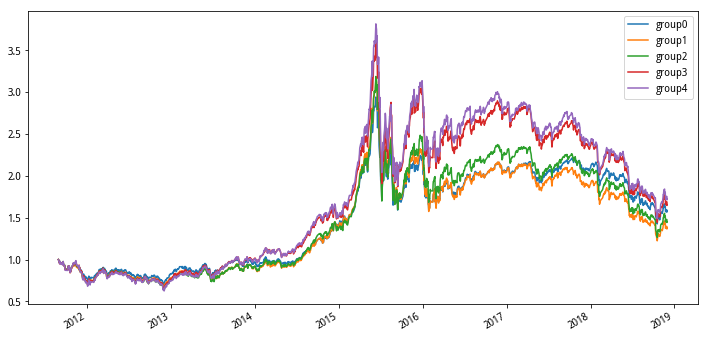

In [99]:
#分组回测部分/'DASTD_1m'
pkl_file = open('volatilty_real_factor.pkl', 'rb')
real_factor_dict = pickle.load(pkl_file)
pkl_file.close()
group = 5 #分组组数
pool_dict = real_factor_dict
key_list = real_factor_dict.keys()
factor_df = pd.DataFrame()
factor_df[0] = pool_dict[list(key_list)[-1]]['DASTD_1m']
for day in key_list:
    regression_factor_df = regression_factor_dict[day]
    y = regression_factor_df['excess_return']
    weight = regression_factor_df['weight']
    X = pd.DataFrame()
    factor_list = ['DASTD_1m']
    for x in factor_list:
        X[x] = regression_factor_df[x]
    mod_wls = sm.WLS(y, X, weights=weight)
    res_wls = mod_wls.fit()
    factor_df[day] = res_wls.fittedvalues 
factor_df = factor_df.T
factor_df = factor_df.drop([0])
for i in range(len(factor_df.index)):
    temp_se = factor_df.iloc[0,:].sort_values(ascending=False)#从大到小排序
    temp_se = temp_se.dropna() #去掉空值
    pool = temp_se.index #不做负值处理
    num = int(len(pool)/group)
    pool_dict[factor_df.index[i]] = pool
trade_list = factor_df.index
group_pct = get_all_pct(pool_dict,trade_list,groups=group)
group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
group_pct.cumprod().plot(figsize=(12,6))

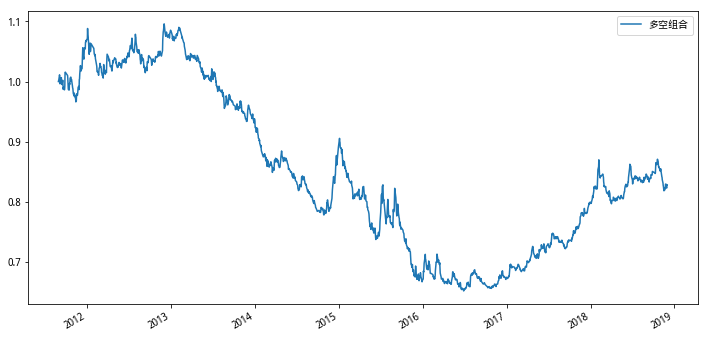

In [100]:
#多空组合收益曲线
se1 = group_pct['group0']-group_pct['group4']+1
df = pd.DataFrame(se1,columns=['多空组合'])
df.cumprod().plot(figsize=(12,6))

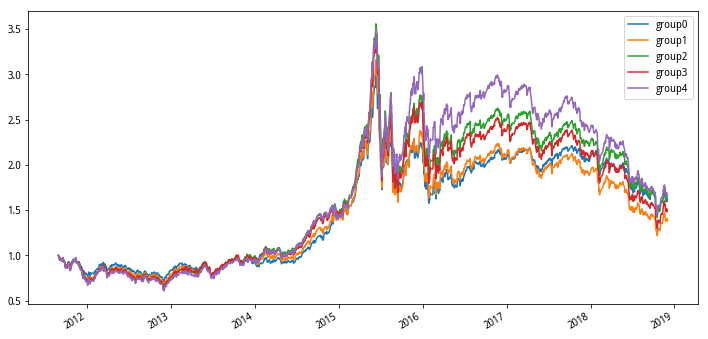

In [105]:
#分组回测部分/'DASTD_3m'
pkl_file = open('volatilty_real_factor.pkl', 'rb')
real_factor_dict = pickle.load(pkl_file)
pkl_file.close()
group = 5 #分组组数
pool_dict = real_factor_dict
key_list = real_factor_dict.keys()
factor_df = pd.DataFrame()
factor_df[0] = pool_dict[list(key_list)[-1]]['DASTD_3m']
for day in key_list:
    regression_factor_df = regression_factor_dict[day]
    y = regression_factor_df['excess_return']
    weight = regression_factor_df['weight']
    X = pd.DataFrame()
    factor_list = ['DASTD_3m']
    for x in factor_list:
        X[x] = regression_factor_df[x]
    mod_wls = sm.WLS(y, X, weights=weight)
    res_wls = mod_wls.fit()
    factor_df[day] = res_wls.fittedvalues
factor_df = factor_df.T
factor_df = factor_df.drop([0])
for i in range(len(factor_df.index)):
    temp_se = factor_df.iloc[0,:].sort_values(ascending=False)#从大到小排序
    temp_se = temp_se.dropna() #去掉空值
    pool = temp_se.index #不做负值处理
    num = int(len(pool)/group)
    pool_dict[factor_df.index[i]] = pool
trade_list = factor_df.index
group_pct = get_all_pct(pool_dict,trade_list,groups=group)
group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
group_pct.cumprod().plot(figsize=(12,6))

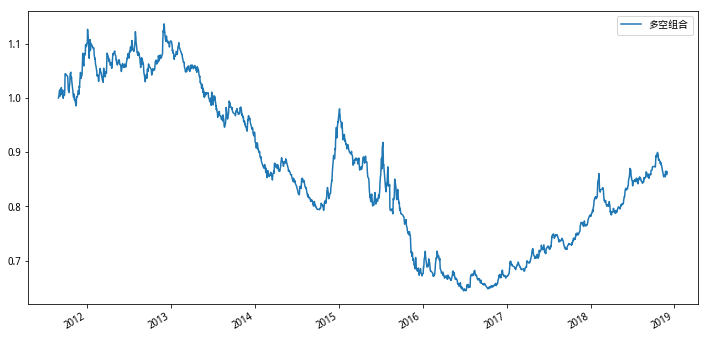

In [106]:
#多空组合收益曲线
se1 = group_pct['group0']-group_pct['group4']+1
df = pd.DataFrame(se1,columns=['多空组合'])
df.cumprod().plot(figsize=(12,6))

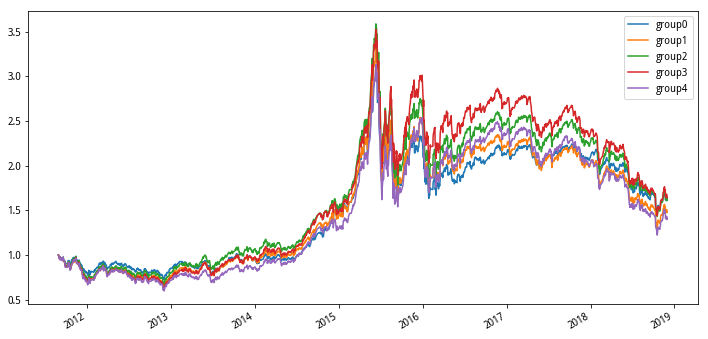

In [107]:
#分组回测部分/'DASTD_6m'
pkl_file = open('volatilty_real_factor.pkl', 'rb')
real_factor_dict = pickle.load(pkl_file)
pkl_file.close()
group = 5 #分组组数
pool_dict = real_factor_dict
key_list = real_factor_dict.keys()
factor_df = pd.DataFrame()
factor_df[0] = pool_dict[list(key_list)[-1]]['DASTD_6m']
for day in key_list:
    regression_factor_df = regression_factor_dict[day]
    y = regression_factor_df['excess_return']
    weight = regression_factor_df['weight']
    X = pd.DataFrame()
    factor_list = ['DASTD_6m']
    for x in factor_list:
        X[x] = regression_factor_df[x]
    mod_wls = sm.WLS(y, X, weights=weight)
    res_wls = mod_wls.fit()
    factor_df[day] = res_wls.fittedvalues 
factor_df = factor_df.T
factor_df = factor_df.drop([0])
for i in range(len(factor_df.index)):
    temp_se = factor_df.iloc[0,:].sort_values(ascending=False)#从大到小排序
    temp_se = temp_se.dropna() #去掉空值
    pool = temp_se.index #不做负值处理
    num = int(len(pool)/group)
    pool_dict[factor_df.index[i]] = pool
trade_list = factor_df.index
group_pct = get_all_pct(pool_dict,trade_list,groups=group)
group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
group_pct.cumprod().plot(figsize=(12,6))

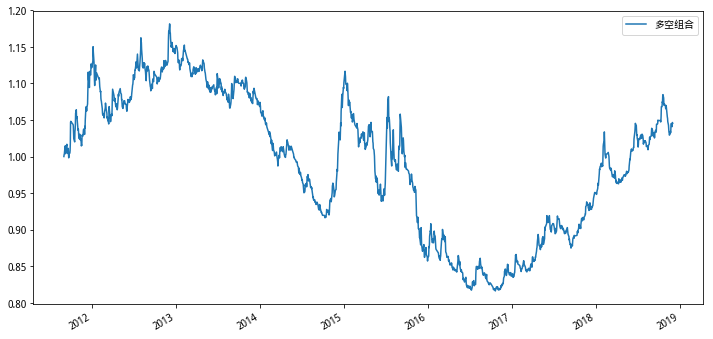

In [108]:
#多空组合收益曲线
se1 = group_pct['group0']-group_pct['group4']+1
df = pd.DataFrame(se1,columns=['多空组合'])
df.cumprod().plot(figsize=(12,6))

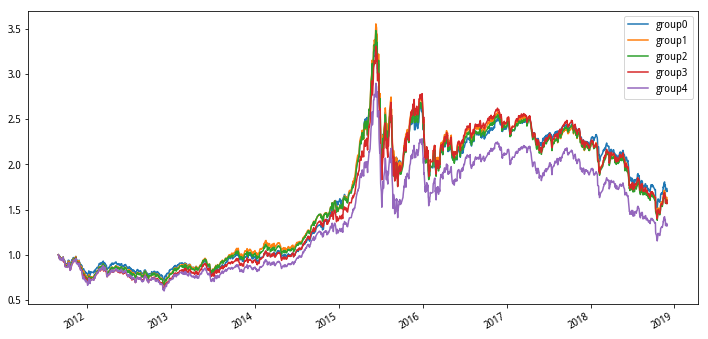

In [109]:
#分组回测部分/'DASTD_1y'
pkl_file = open('volatilty_real_factor.pkl', 'rb')
real_factor_dict = pickle.load(pkl_file)
pkl_file.close()
group = 5 #分组组数
pool_dict = real_factor_dict
key_list = real_factor_dict.keys()
factor_df = pd.DataFrame()
factor_df[0] = pool_dict[list(key_list)[-1]]['DASTD_1y']
for day in key_list:
    regression_factor_df = regression_factor_dict[day]
    y = regression_factor_df['excess_return']
    weight = regression_factor_df['weight']
    X = pd.DataFrame()
    factor_list = ['DASTD_1y']
    for x in factor_list:
        X[x] = regression_factor_df[x]
    mod_wls = sm.WLS(y, X, weights=weight)
    res_wls = mod_wls.fit()
    factor_df[day] = res_wls.fittedvalues 
factor_df = factor_df.T
factor_df = factor_df.drop([0])
for i in range(len(factor_df.index)):
    temp_se = factor_df.iloc[0,:].sort_values(ascending=False)#从大到小排序
    temp_se = temp_se.dropna() #去掉空值
    pool = temp_se.index #不做负值处理
    num = int(len(pool)/group)
    pool_dict[factor_df.index[i]] = pool
trade_list = factor_df.index
group_pct = get_all_pct(pool_dict,trade_list,groups=group)
group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
group_pct.cumprod().plot(figsize=(12,6))

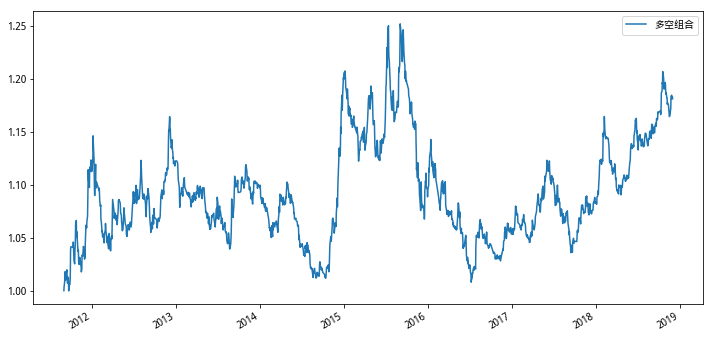

In [110]:
#多空组合收益曲线
se1 = group_pct['group0']-group_pct['group4']+1
df = pd.DataFrame(se1,columns=['多空组合'])
df.cumprod().plot(figsize=(12,6))

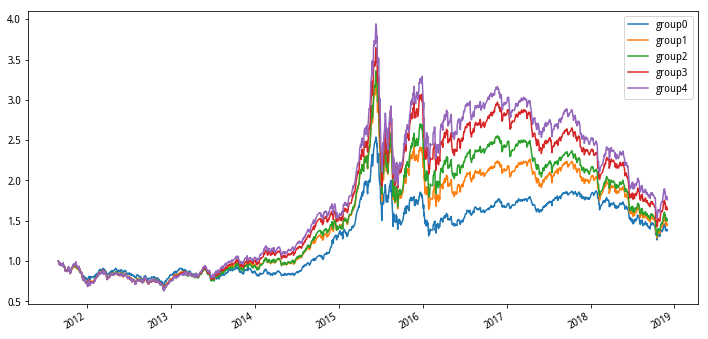

In [56]:
#分组回测部分/市值中性的'DASTD_1m'
pkl_file = open('volatilty_real_factor.pkl', 'rb')
real_factor_dict = pickle.load(pkl_file)
pkl_file.close()
group = 5 #分组组数
pool_dict = real_factor_dict
key_list = real_factor_dict.keys()
factor_df = pd.DataFrame()
factor_df[0] = pool_dict[list(key_list)[-1]]['DASTD_1m']
for day in key_list:    
    regression_factor_df = regression_factor_dict[day]
    y = regression_factor_df['excess_return']
    weight = regression_factor_df['weight']
    X = pd.DataFrame()
    factor_list = ['DASTD_1m', 'value']
    for x in factor_list:
        X[x] = regression_factor_df[x]
    mod_wls = sm.WLS(y, X, weights=weight)
    res_wls = mod_wls.fit()
    factor_df[day] = res_wls.fittedvalues    
factor_df = factor_df.T
factor_df = factor_df.drop([0])
for i in range(len(factor_df.index)):
    temp_se = factor_df.iloc[0,:].sort_values(ascending=False)#从大到小排序
    temp_se = temp_se.dropna() #去掉空值
    pool = temp_se.index #不做负值处理
    num = int(len(pool)/group)
    pool_dict[factor_df.index[i]] = pool
trade_list = factor_df.index
group_pct = get_all_pct(pool_dict,trade_list,groups=group)
group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
group_pct.cumprod().plot(figsize=(12,6))

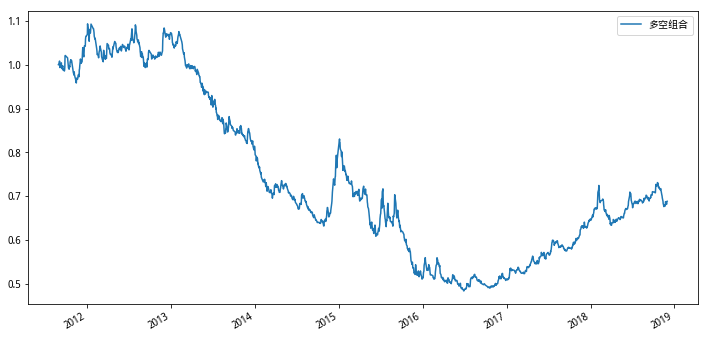

In [57]:
#多空组合收益曲线
se1 = group_pct['group0']-group_pct['group4']+1
df = pd.DataFrame(se1,columns=['多空组合'])
df.cumprod().plot(figsize=(12,6))

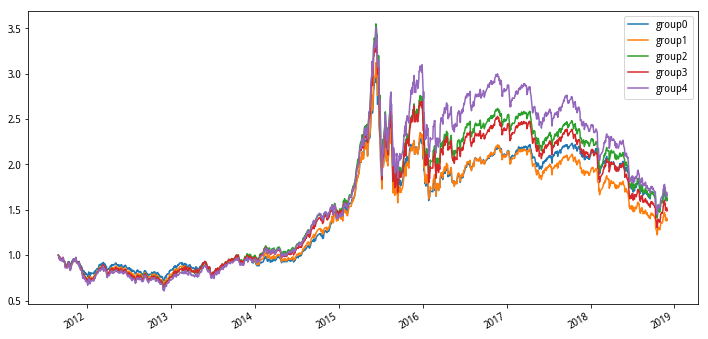

In [58]:
#分组回测部分/市值中性的'DASTD_3m'
pkl_file = open('volatilty_real_factor.pkl', 'rb')
real_factor_dict = pickle.load(pkl_file)
pkl_file.close()
group = 5 #分组组数
pool_dict = real_factor_dict
key_list = real_factor_dict.keys()
factor_df = pd.DataFrame()
factor_df[0] = pool_dict[list(key_list)[-1]]['DASTD_3m']
for day in key_list:    
    regression_factor_df = regression_factor_dict[day]
    y = regression_factor_df['excess_return']
    weight = regression_factor_df['weight']
    X = pd.DataFrame()
    factor_list = ['DASTD_3m', 'value']
    for x in factor_list:
        X[x] = regression_factor_df[x]
    mod_wls = sm.WLS(y, X, weights=weight)
    res_wls = mod_wls.fit()
    factor_df[day] = res_wls.fittedvalues    
factor_df = factor_df.T
factor_df = factor_df.drop([0])
for i in range(len(factor_df.index)):
    temp_se = factor_df.iloc[0,:].sort_values(ascending=False)#从大到小排序
    temp_se = temp_se.dropna() #去掉空值
    pool = temp_se.index #不做负值处理
    num = int(len(pool)/group)
    pool_dict[factor_df.index[i]] = pool
trade_list = factor_df.index
group_pct = get_all_pct(pool_dict,trade_list,groups=group)
group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
group_pct.cumprod().plot(figsize=(12,6))

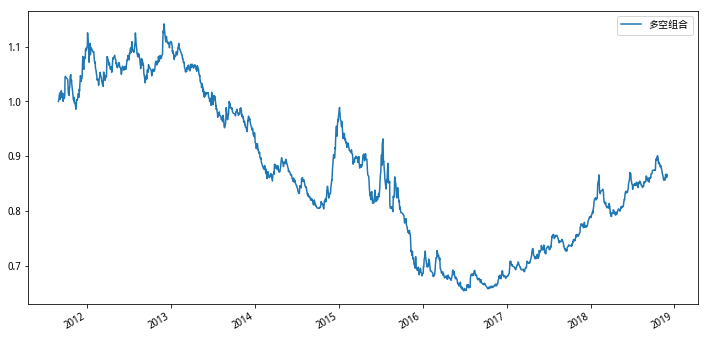

In [59]:
#多空组合收益曲线
se1 = group_pct['group0']-group_pct['group4']+1
df = pd.DataFrame(se1,columns=['多空组合'])
df.cumprod().plot(figsize=(12,6))

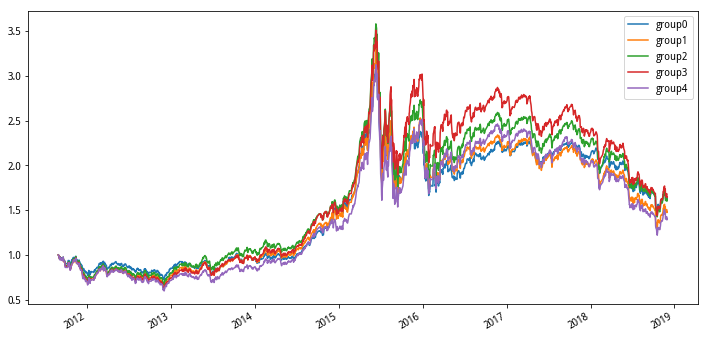

In [60]:
#分组回测部分/市值中性的'DASTD_6m'
pkl_file = open('volatilty_real_factor.pkl', 'rb')
real_factor_dict = pickle.load(pkl_file)
pkl_file.close()
group = 5 #分组组数
pool_dict = real_factor_dict
key_list = real_factor_dict.keys()
factor_df = pd.DataFrame()
factor_df[0] = pool_dict[list(key_list)[-1]]['DASTD_6m']
for day in key_list:    
    regression_factor_df = regression_factor_dict[day]
    y = regression_factor_df['excess_return']
    weight = regression_factor_df['weight']
    X = pd.DataFrame()
    factor_list = ['DASTD_6m', 'value']
    for x in factor_list:
        X[x] = regression_factor_df[x]
    mod_wls = sm.WLS(y, X, weights=weight)
    res_wls = mod_wls.fit()
    factor_df[day] = res_wls.fittedvalues    
factor_df = factor_df.T
factor_df = factor_df.drop([0])
for i in range(len(factor_df.index)):
    temp_se = factor_df.iloc[0,:].sort_values(ascending=False)#从大到小排序
    temp_se = temp_se.dropna() #去掉空值
    pool = temp_se.index #不做负值处理
    num = int(len(pool)/group)
    pool_dict[factor_df.index[i]] = pool
trade_list = factor_df.index
group_pct = get_all_pct(pool_dict,trade_list,groups=group)
group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
group_pct.cumprod().plot(figsize=(12,6))

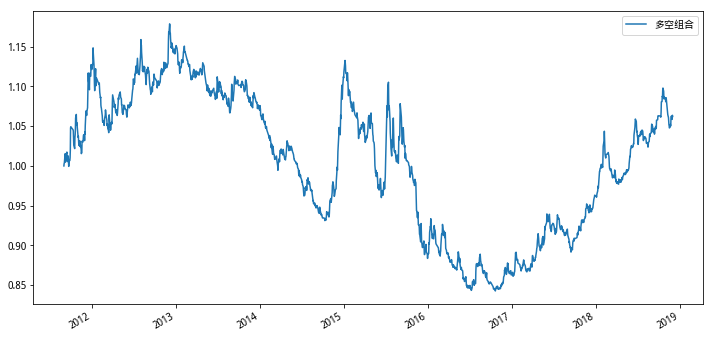

In [61]:
#多空组合收益曲线
se1 = group_pct['group0']-group_pct['group4']+1
df = pd.DataFrame(se1,columns=['多空组合'])
df.cumprod().plot(figsize=(12,6))

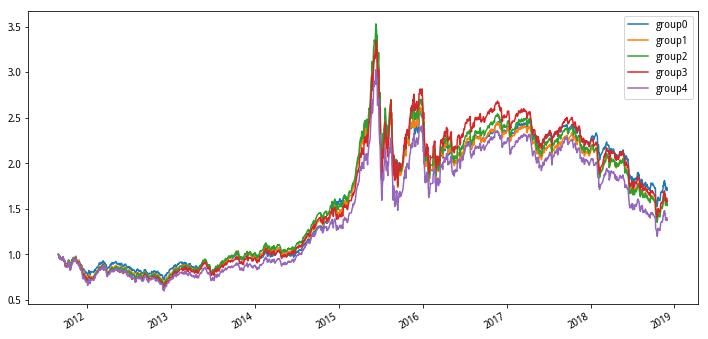

In [62]:
#分组回测部分/市值中性的'DASTD_1y'
pkl_file = open('volatilty_real_factor.pkl', 'rb')
real_factor_dict = pickle.load(pkl_file)
pkl_file.close()
group = 5 #分组组数
pool_dict = real_factor_dict
key_list = real_factor_dict.keys()
factor_df = pd.DataFrame()
factor_df[0] = pool_dict[list(key_list)[-1]]['DASTD_1y']
for day in key_list:    
    regression_factor_df = regression_factor_dict[day]
    y = regression_factor_df['excess_return']
    weight = regression_factor_df['weight']
    X = pd.DataFrame()
    factor_list = ['DASTD_1', 'value']
    for x in factor_list:
        X[x] = regression_factor_df[x]
    mod_wls = sm.WLS(y, X, weights=weight)
    res_wls = mod_wls.fit()
    factor_df[day] = res_wls.fittedvalues    
factor_df = factor_df.T
factor_df = factor_df.drop([0])
for i in range(len(factor_df.index)):
    temp_se = factor_df.iloc[0,:].sort_values(ascending=False)#从大到小排序
    temp_se = temp_se.dropna() #去掉空值
    pool = temp_se.index #不做负值处理
    num = int(len(pool)/group)
    pool_dict[factor_df.index[i]] = pool
trade_list = factor_df.index
group_pct = get_all_pct(pool_dict,trade_list,groups=group)
group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
group_pct.cumprod().plot(figsize=(12,6))

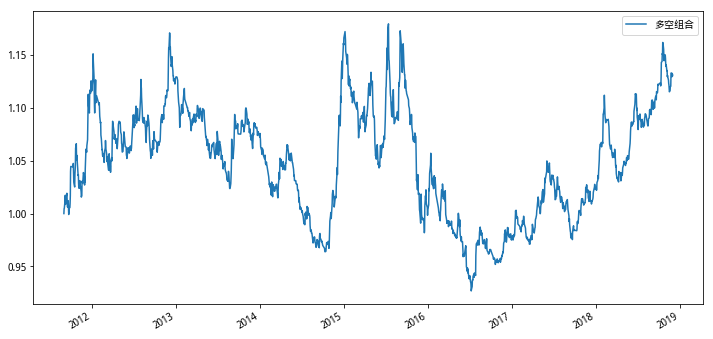

In [63]:
#多空组合收益曲线
se1 = group_pct['group0']-group_pct['group4']+1
df = pd.DataFrame(se1,columns=['多空组合'])
df.cumprod().plot(figsize=(12,6))

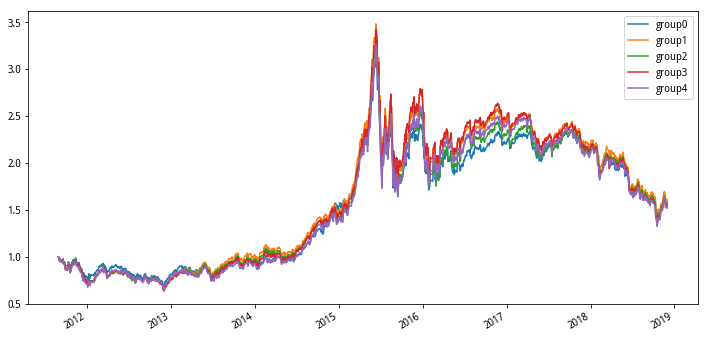

In [64]:
#分组回测部分/行业中性的'DASTD_1m'
pkl_file = open('volatilty_real_factor.pkl', 'rb')
real_factor_dict = pickle.load(pkl_file)
pkl_file.close()
group = 5 #分组组数
pool_dict = real_factor_dict
key_list = real_factor_dict.keys()
factor_df = pd.DataFrame()
factor_df[0] = pool_dict[list(key_list)[-1]]['DASTD_1m']
industry_list = list(get_industries(name='sw_l1').index)
for day in key_list:    
    regression_factor_df = regression_factor_dict[day]
    y = regression_factor_df['excess_return']
    weight = regression_factor_df['weight']
    X = pd.DataFrame()
    factor_list = ['DASTD_1m']
    for industry in industry_list:
        factor_list.append(industry)
    for x in factor_list:
        X[x] = regression_factor_df[x]
    mod_wls = sm.WLS(y, X, weights=weight)
    res_wls = mod_wls.fit()
    factor_df[day] = res_wls.fittedvalues    
factor_df = factor_df.T
factor_df = factor_df.drop([0])
for i in range(len(factor_df.index)):
    temp_se = factor_df.iloc[0,:].sort_values(ascending=False)#从大到小排序
    temp_se = temp_se.dropna() #去掉空值
    pool = temp_se.index #不做负值处理
    num = int(len(pool)/group)
    pool_dict[factor_df.index[i]] = pool
trade_list = factor_df.index
group_pct = get_all_pct(pool_dict,trade_list,groups=group)
group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
group_pct.cumprod().plot(figsize=(12,6))

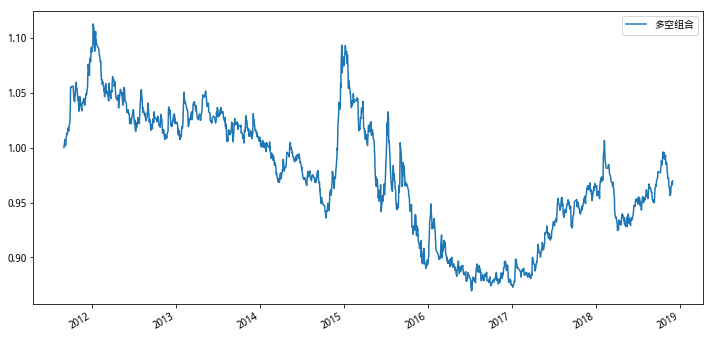

In [65]:
#多空组合收益曲线
se1 = group_pct['group0']-group_pct['group4']+1
df = pd.DataFrame(se1,columns=['多空组合'])
df.cumprod().plot(figsize=(12,6))

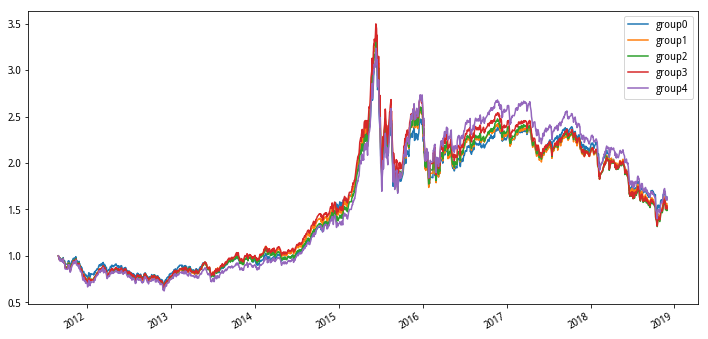

In [66]:
#分组回测部分/行业中性的'DASTD_3m'
pkl_file = open('volatilty_real_factor.pkl', 'rb')
real_factor_dict = pickle.load(pkl_file)
pkl_file.close()
group = 5 #分组组数
pool_dict = real_factor_dict
key_list = real_factor_dict.keys()
factor_df = pd.DataFrame()
factor_df[0] = pool_dict[list(key_list)[-1]]['DASTD_3m']
industry_list = list(get_industries(name='sw_l1').index)
for day in key_list:    
    regression_factor_df = regression_factor_dict[day]
    y = regression_factor_df['excess_return']
    weight = regression_factor_df['weight']
    X = pd.DataFrame()
    factor_list = ['DASTD_3m']
    for industry in industry_list:
        factor_list.append(industry)
    for x in factor_list:
        X[x] = regression_factor_df[x]
    mod_wls = sm.WLS(y, X, weights=weight)
    res_wls = mod_wls.fit()
    factor_df[day] = res_wls.fittedvalues    
factor_df = factor_df.T
factor_df = factor_df.drop([0])
for i in range(len(factor_df.index)):
    temp_se = factor_df.iloc[0,:].sort_values(ascending=False)#从大到小排序
    temp_se = temp_se.dropna() #去掉空值
    pool = temp_se.index #不做负值处理
    num = int(len(pool)/group)
    pool_dict[factor_df.index[i]] = pool
trade_list = factor_df.index
group_pct = get_all_pct(pool_dict,trade_list,groups=group)
group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
group_pct.cumprod().plot(figsize=(12,6))

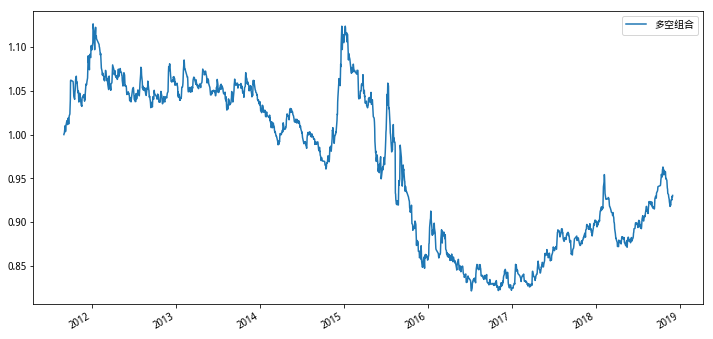

In [67]:
#多空组合收益曲线
se1 = group_pct['group0']-group_pct['group4']+1
df = pd.DataFrame(se1,columns=['多空组合'])
df.cumprod().plot(figsize=(12,6))

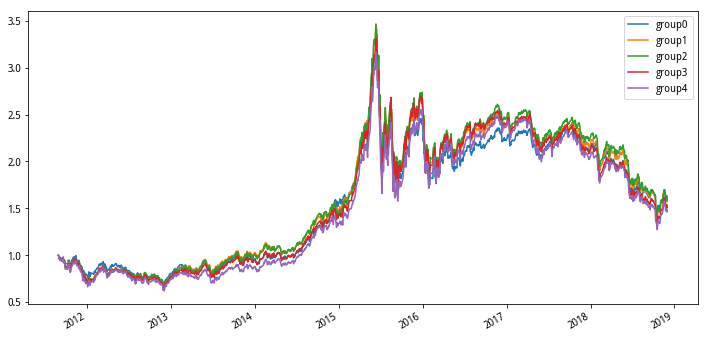

In [68]:
#分组回测部分/行业中性的'DASTD_6m'
pkl_file = open('volatilty_real_factor.pkl', 'rb')
real_factor_dict = pickle.load(pkl_file)
pkl_file.close()
group = 5 #分组组数
pool_dict = real_factor_dict
key_list = real_factor_dict.keys()
factor_df = pd.DataFrame()
factor_df[0] = pool_dict[list(key_list)[-1]]['DASTD_6m']
industry_list = list(get_industries(name='sw_l1').index)
for day in key_list:    
    regression_factor_df = regression_factor_dict[day]
    y = regression_factor_df['excess_return']
    weight = regression_factor_df['weight']
    X = pd.DataFrame()
    factor_list = ['DASTD_6m']
    for industry in industry_list:
        factor_list.append(industry)
    for x in factor_list:
        X[x] = regression_factor_df[x]
    mod_wls = sm.WLS(y, X, weights=weight)
    res_wls = mod_wls.fit()
    factor_df[day] = res_wls.fittedvalues    
factor_df = factor_df.T
factor_df = factor_df.drop([0])
for i in range(len(factor_df.index)):
    temp_se = factor_df.iloc[0,:].sort_values(ascending=False)#从大到小排序
    temp_se = temp_se.dropna() #去掉空值
    pool = temp_se.index #不做负值处理
    num = int(len(pool)/group)
    pool_dict[factor_df.index[i]] = pool
trade_list = factor_df.index
group_pct = get_all_pct(pool_dict,trade_list,groups=group)
group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
group_pct.cumprod().plot(figsize=(12,6))

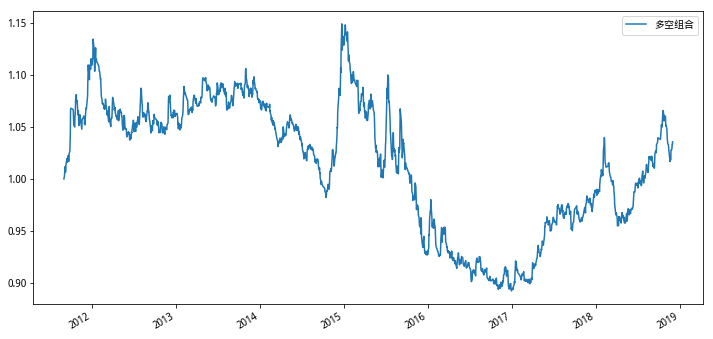

In [69]:
#多空组合收益曲线
se1 = group_pct['group0']-group_pct['group4']+1
df = pd.DataFrame(se1,columns=['多空组合'])
df.cumprod().plot(figsize=(12,6))

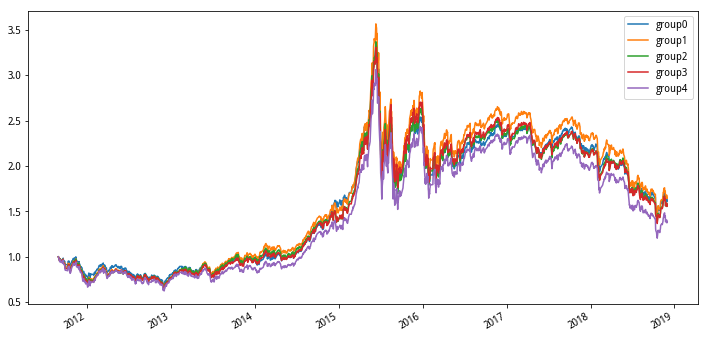

In [70]:
#分组回测部分/行业中性的'DASTD_1y'
pkl_file = open('volatilty_real_factor.pkl', 'rb')
real_factor_dict = pickle.load(pkl_file)
pkl_file.close()
group = 5 #分组组数
pool_dict = real_factor_dict
key_list = real_factor_dict.keys()
factor_df = pd.DataFrame()
factor_df[0] = pool_dict[list(key_list)[-1]]['DASTD_1y']
industry_list = list(get_industries(name='sw_l1').index)
for day in key_list:    
    regression_factor_df = regression_factor_dict[day]
    y = regression_factor_df['excess_return']
    weight = regression_factor_df['weight']
    X = pd.DataFrame()
    factor_list = ['DASTD_1y']
    for industry in industry_list:
        factor_list.append(industry)
    for x in factor_list:
        X[x] = regression_factor_df[x]
    mod_wls = sm.WLS(y, X, weights=weight)
    res_wls = mod_wls.fit()
    factor_df[day] = res_wls.fittedvalues    
factor_df = factor_df.T
factor_df = factor_df.drop([0])
for i in range(len(factor_df.index)):
    temp_se = factor_df.iloc[0,:].sort_values(ascending=False)#从大到小排序
    temp_se = temp_se.dropna() #去掉空值
    pool = temp_se.index #不做负值处理
    num = int(len(pool)/group)
    pool_dict[factor_df.index[i]] = pool
trade_list = factor_df.index
group_pct = get_all_pct(pool_dict,trade_list,groups=group)
group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
group_pct.cumprod().plot(figsize=(12,6))

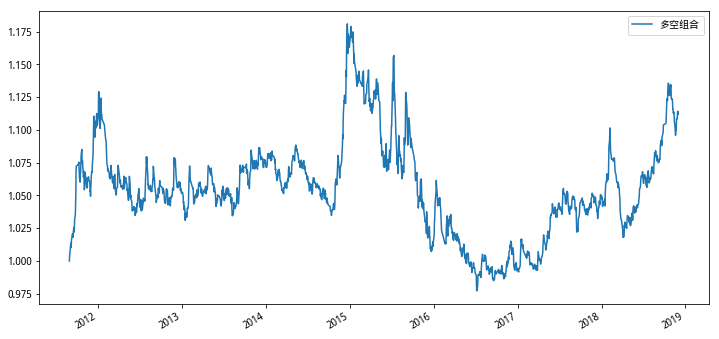

In [71]:
#多空组合收益曲线
se1 = group_pct['group0']-group_pct['group4']+1
df = pd.DataFrame(se1,columns=['多空组合'])
df.cumprod().plot(figsize=(12,6))

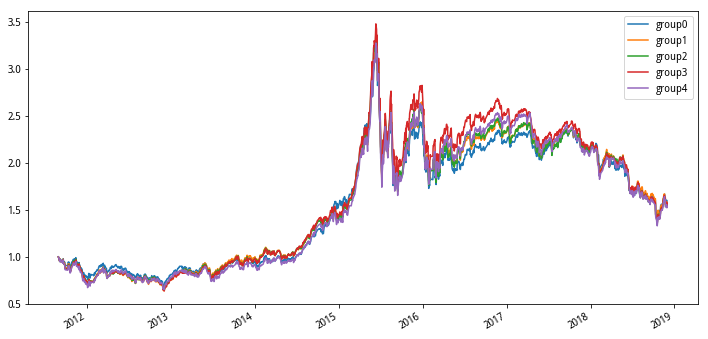

In [48]:
#分组回测部分/市值与行业中性的'DASTD_1m'
pkl_file = open('volatilty_real_factor.pkl', 'rb')
real_factor_dict = pickle.load(pkl_file)
pkl_file.close()
group = 5 #分组组数
pool_dict = real_factor_dict
key_list = real_factor_dict.keys()
factor_df = pd.DataFrame()
factor_df[0] = pool_dict[list(key_list)[-1]]['DASTD_1m']
industry_list = list(get_industries(name='sw_l1').index)
for day in key_list:    
    regression_factor_df = regression_factor_dict[day]
    y = regression_factor_df['excess_return']
    weight = regression_factor_df['weight']
    X = pd.DataFrame()
    factor_list = ['DASTD_1m', 'value']
    for industry in industry_list:
        factor_list.append(industry)
    for x in factor_list:
        X[x] = regression_factor_df[x]
    mod_wls = sm.WLS(y, X, weights=weight)
    res_wls = mod_wls.fit()
    factor_df[day] = res_wls.fittedvalues    
factor_df = factor_df.T
factor_df = factor_df.drop([0])
for i in range(len(factor_df.index)):
    temp_se = factor_df.iloc[0,:].sort_values(ascending=False)#从大到小排序
    temp_se = temp_se.dropna() #去掉空值
    pool = temp_se.index #不做负值处理
    num = int(len(pool)/group)
    pool_dict[factor_df.index[i]] = pool
trade_list = factor_df.index
group_pct = get_all_pct(pool_dict,trade_list,groups=group)
group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
group_pct.cumprod().plot(figsize=(12,6))

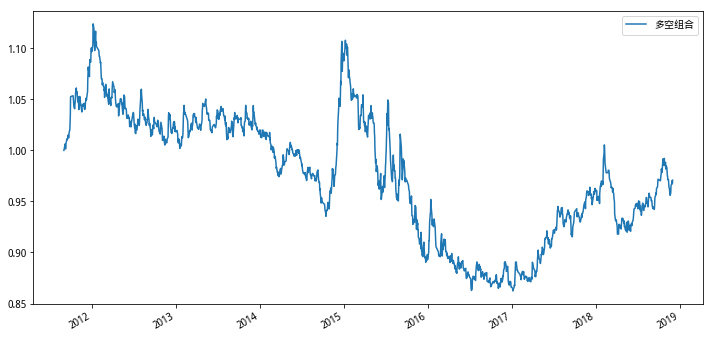

In [49]:
#多空组合收益曲线
se1 = group_pct['group0']-group_pct['group4']+1
df = pd.DataFrame(se1,columns=['多空组合'])
df.cumprod().plot(figsize=(12,6))

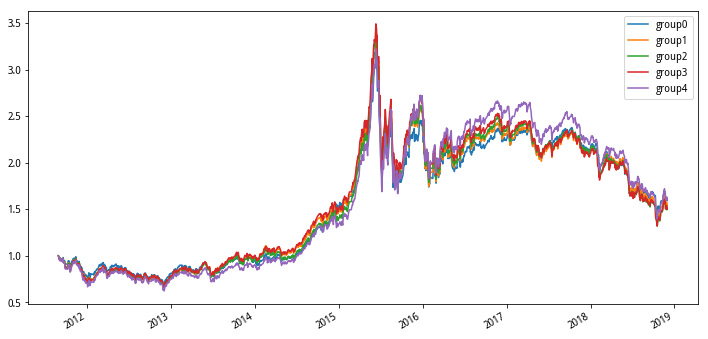

In [50]:
#分组回测部分/市值与行业中性的'DASTD_3m'
pkl_file = open('volatilty_real_factor.pkl', 'rb')
real_factor_dict = pickle.load(pkl_file)
pkl_file.close()
group = 5 #分组组数
pool_dict = real_factor_dict
key_list = real_factor_dict.keys()
factor_df = pd.DataFrame()
factor_df[0] = pool_dict[list(key_list)[-1]]['DASTD_3m']
industry_list = list(get_industries(name='sw_l1').index)
for day in key_list:    
    regression_factor_df = regression_factor_dict[day]
    y = regression_factor_df['excess_return']
    weight = regression_factor_df['weight']
    X = pd.DataFrame()
    factor_list = ['DASTD_3m', 'value']
    for industry in industry_list:
        factor_list.append(industry)
    for x in factor_list:
        X[x] = regression_factor_df[x]
    mod_wls = sm.WLS(y, X, weights=weight)
    res_wls = mod_wls.fit()
    factor_df[day] = res_wls.fittedvalues    
factor_df = factor_df.T
factor_df = factor_df.drop([0])
for i in range(len(factor_df.index)):
    temp_se = factor_df.iloc[0,:].sort_values(ascending=False)#从大到小排序
    temp_se = temp_se.dropna() #去掉空值
    pool = temp_se.index #不做负值处理
    num = int(len(pool)/group)
    pool_dict[factor_df.index[i]] = pool
trade_list = factor_df.index
group_pct = get_all_pct(pool_dict,trade_list,groups=group)
group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
group_pct.cumprod().plot(figsize=(12,6))

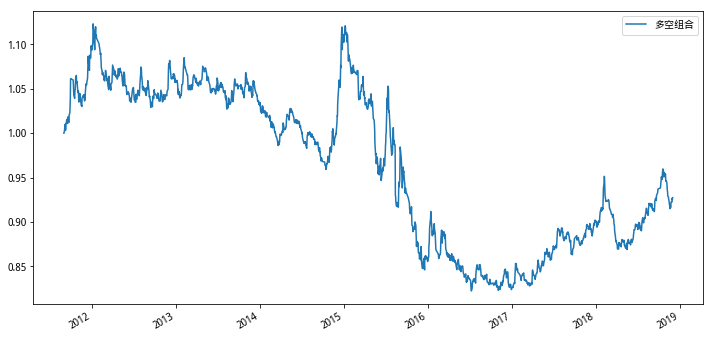

In [51]:
#多空组合收益曲线
se1 = group_pct['group0']-group_pct['group4']+1
df = pd.DataFrame(se1,columns=['多空组合'])
df.cumprod().plot(figsize=(12,6))

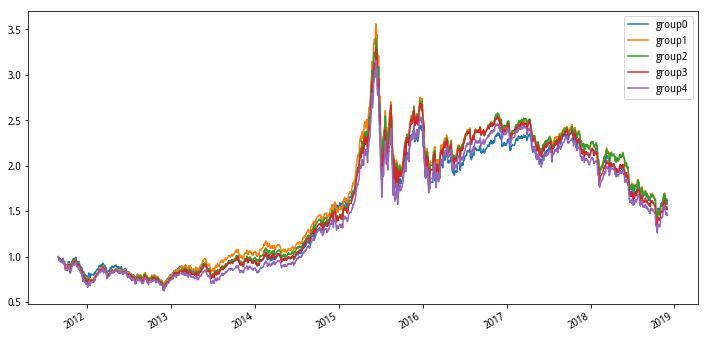

In [52]:
#分组回测部分/市值与行业中性的'DASTD_6m'
pkl_file = open('volatilty_real_factor.pkl', 'rb')
real_factor_dict = pickle.load(pkl_file)
pkl_file.close()
group = 5 #分组组数
pool_dict = real_factor_dict
key_list = real_factor_dict.keys()
factor_df = pd.DataFrame()
factor_df[0] = pool_dict[list(key_list)[-1]]['DASTD_6m']
industry_list = list(get_industries(name='sw_l1').index)
for day in key_list:    
    regression_factor_df = regression_factor_dict[day]
    y = regression_factor_df['excess_return']
    weight = regression_factor_df['weight']
    X = pd.DataFrame()
    factor_list = ['DASTD_6m', 'value']
    for industry in industry_list:
        factor_list.append(industry)
    for x in factor_list:
        X[x] = regression_factor_df[x]
    mod_wls = sm.WLS(y, X, weights=weight)
    res_wls = mod_wls.fit()
    factor_df[day] = res_wls.fittedvalues    
factor_df = factor_df.T
factor_df = factor_df.drop([0])
for i in range(len(factor_df.index)):
    temp_se = factor_df.iloc[0,:].sort_values(ascending=False)#从大到小排序
    temp_se = temp_se.dropna() #去掉空值
    pool = temp_se.index #不做负值处理
    num = int(len(pool)/group)
    pool_dict[factor_df.index[i]] = pool
trade_list = factor_df.index
group_pct = get_all_pct(pool_dict,trade_list,groups=group)
group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
group_pct.cumprod().plot(figsize=(12,6))

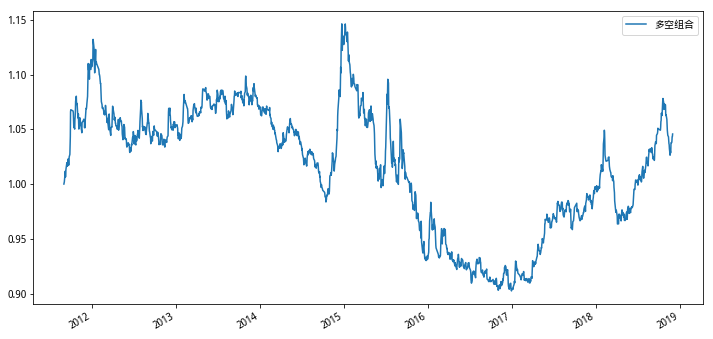

In [53]:
#多空组合收益曲线
se1 = group_pct['group0']-group_pct['group4']+1
df = pd.DataFrame(se1,columns=['多空组合'])
df.cumprod().plot(figsize=(12,6))

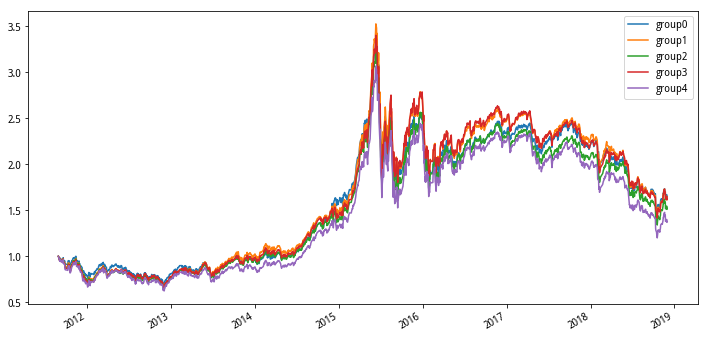

In [54]:
#分组回测部分/市值与行业中性的'DASTD_1y'
pkl_file = open('volatilty_real_factor.pkl', 'rb')
real_factor_dict = pickle.load(pkl_file)
pkl_file.close()
group = 5 #分组组数
pool_dict = real_factor_dict
key_list = real_factor_dict.keys()
factor_df = pd.DataFrame()
factor_df[0] = pool_dict[list(key_list)[-1]]['DASTD_1y']
industry_list = list(get_industries(name='sw_l1').index)
for day in key_list:    
    regression_factor_df = regression_factor_dict[day]
    y = regression_factor_df['excess_return']
    weight = regression_factor_df['weight']
    X = pd.DataFrame()
    factor_list = ['DASTD_1y', 'value']
    for industry in industry_list:
        factor_list.append(industry)
    for x in factor_list:
        X[x] = regression_factor_df[x]
    mod_wls = sm.WLS(y, X, weights=weight)
    res_wls = mod_wls.fit()
    factor_df[day] = res_wls.fittedvalues    
factor_df = factor_df.T
factor_df = factor_df.drop([0])
for i in range(len(factor_df.index)):
    temp_se = factor_df.iloc[0,:].sort_values(ascending=False)#从大到小排序
    temp_se = temp_se.dropna() #去掉空值
    pool = temp_se.index #不做负值处理
    num = int(len(pool)/group)
    pool_dict[factor_df.index[i]] = pool
trade_list = factor_df.index
group_pct = get_all_pct(pool_dict,trade_list,groups=group)
group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
group_pct.cumprod().plot(figsize=(12,6))

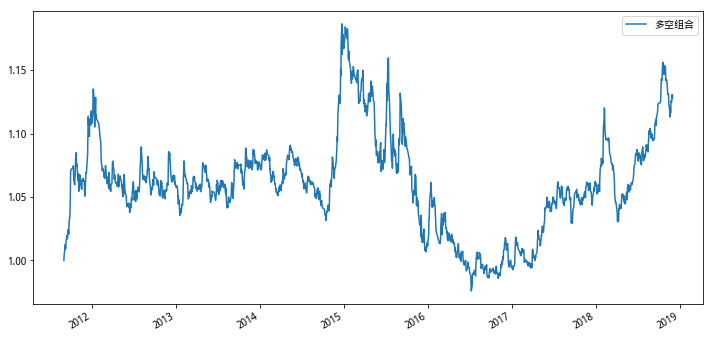

In [55]:
#多空组合收益曲线
se1 = group_pct['group0']-group_pct['group4']+1
df = pd.DataFrame(se1,columns=['多空组合'])
df.cumprod().plot(figsize=(12,6))